<a href="https://colab.research.google.com/github/anphantt2406/Heritage-Health-Prize/blob/main/3_Model_DroppedVersion%26FeatureSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/HHP_release3/data_processed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/HHP_release3/data_processed


#Import Library

In [36]:
import glob
import math
import pandas as pd
import numpy as np
import xgboost
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.neural_network import MLPRegressor
from sklearn import datasets, ensemble
from sklearn.datasets import make_regression

import seaborn as sns # Library for plotting
color = sns.color_palette()
sns.set_style('darkgrid')
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#Define some needed function

Predictions are evaluated using root mean squared logarithmic error, referred to henceforth as RMSLE.

$$\varepsilon = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(log(p_i+1) - log(a_i+1)^2 \right )}$$

Where:



*   $i$ is a patient's unique MemberID
*   $n$ is the total number of patients
*   $p_i$ is the prediction made for patient $i$
*   $a_i$ is the actual number of days spent in the hospital by patient $i$





In [37]:
def RMSLE_cal(pred, actu, name=None):
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    print('RMSLE', name, ':', RMSLE)

In [38]:
def rmsle(pred, dtrain):
    """Used for stacked in Xgboost
    """
    actu = dtrain.get_label()
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    return 'RMSLE', RMSLE

In [39]:
def eval(model, X_test, y_test, name = None):
    pred_y = model.predict(X_test) # your predicted y values
    # The root mean square logarithmic error
    pred_y = pred_y.clip(min=0)
    pred_y = pred_y.clip(max=15)
    pred_y = pred_y.round(0).astype(int)
    msle = np.mean( (np.log(pred_y + 1) - np.log(y_test + 1)) ** 2)
    rmsle = math.sqrt(msle)
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test,pred_y)
    from sklearn.metrics import mean_squared_log_error
    err = math.sqrt(mean_squared_log_error(y_test,pred_y))
    print("RMSLE of", name, ": %.4f" %rmsle)
    print("R2 value of", name, ": %.4f" %r2)
    print("Err value of", name, ": %.4f" %err)

In [40]:
def plotResult(results, cv=None):
    fig, ax = plt.subplots()
    if cv:
        ax.plot(range(results.shape[0]), results['train-RMSLE-mean'])
        ax.plot(range(results.shape[0]), results['test-RMSLE-mean'])
    else:
        ax.plot(range(len(results['train']['RMSLE'])), results['train']['RMSLE'])
        ax.plot(range(len(results['test']['RMSLE'])), results['test']['RMSLE'])
        
    ax.set(xlabel='Boost round', ylabel='RMSLE', title='Train/Test RMSLE')
    ax.grid()

    train_patch = mpatches.Patch(color='blue', label='Train')
    test_patch = mpatches.Patch(color='orange', label='Test')

    plt.legend(handles=[train_patch, test_patch])
    plt.show()

#Prepare data for training and testing

In this notebook, we use Claims data in Year 1 for training and validation, Claims data in Year 2 for testing.

In [41]:
dataY1_df = pd.read_csv('fulldataY1.csv')
dataY2_df = pd.read_csv('fulldataY2.csv')

In [42]:
dataY1_df = dataY1_df[['MemberID',
 'AgeAtFirstClaim',
 'Unknown',
 'no_Claims',
 'no_Providers',
 'no_Specialties',
 'no_PCG',
 'no_Procedure',
 'sum_PayDelay',
 'Specialty_Diagnostic Imaging',
 'Specialty_Emergency',
 'Specialty_Internal',
 'Specialty_Laboratory',
 'Place_Inpatient Hospital',
 'Place_Office',
 'Place_Urgent Care',
 'DSFS_10-11 months',
 'DSFS_6- 7 months',
 'DSFS_7- 8 months',
 'DSFS_8- 9 months',
 'Charlson_1-2',
 'Procedure_EM',
 'Procedure_MED',
 'Procedure_RAD',
 'DrugSum',
 'LabSum',
 'TARGET']]

dataY2_df = dataY2_df[['MemberID',
 'AgeAtFirstClaim',
 'Unknown',
 'no_Claims',
 'no_Providers',
 'no_Specialties',
 'no_PCG',
 'no_Procedure',
 'sum_PayDelay',
 'Specialty_Diagnostic Imaging',
 'Specialty_Emergency',
 'Specialty_Internal',
 'Specialty_Laboratory',
 'Place_Inpatient Hospital',
 'Place_Office',
 'Place_Urgent Care',
 'DSFS_10-11 months',
 'DSFS_6- 7 months',
 'DSFS_7- 8 months',
 'DSFS_8- 9 months',
 'Charlson_1-2',
 'Procedure_EM',
 'Procedure_MED',
 'Procedure_RAD',
 'DrugSum',
 'LabSum',
 'TARGET']]

In [43]:
dataY1 = dataY1_df.drop("MemberID", axis = 1)
y = dataY1['TARGET']
X = dataY1.drop(['TARGET'], axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [45]:
dataY2 = dataY2_df.drop("MemberID", axis = 1)
y_test = dataY2['TARGET']
X_test = dataY2.drop(['TARGET'], axis = 1)
X_test = scaler.transform(X_test)

# Regression

## MODEL 1: Linear Regression

RMSLE of linear regression : 0.4900
R2 value of linear regression : -0.0023
Err value of linear regression : 0.4900


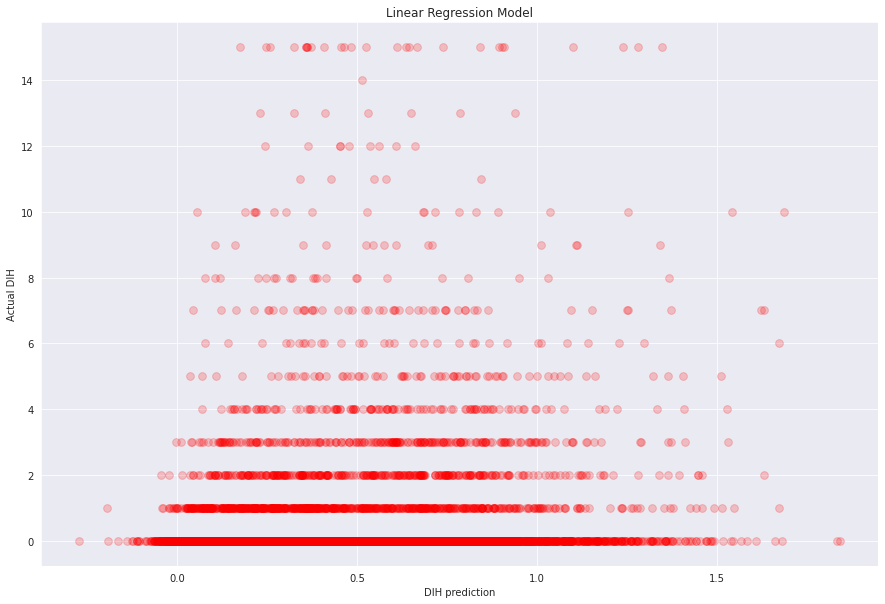

In [46]:
# Create linear regression object
model_1 = LinearRegression()
# Train the model using the training sets
model_1.fit(X_train, y_train)
# Predict on Test set
y_pred_1 = model_1.predict(X_valid)

# Evaluation on Validation set
eval(model_1, X_valid, y_valid,'linear regression')

plt.figure(figsize = (15,10))
plt.scatter(y_pred_1, y_valid, alpha=.2, s = 60, color='r') #alpha helps to show overlapping data
plt.xlabel('DIH prediction')
plt.ylabel('Actual DIH')
plt.title('Linear Regression Model')
plt.show()

## MODEL 2: Stochastic Gradient Descent

In [47]:
from sklearn.linear_model import SGDRegressor

model_2 = SGDRegressor(max_iter=3000, tol=1e-1)
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_valid)
eval(model_2, X_valid, y_valid, 'Stochastic Gradient Descent')

RMSLE of Stochastic Gradient Descent : 0.5064
R2 value of Stochastic Gradient Descent : -0.0108
Err value of Stochastic Gradient Descent : 0.5064


In [48]:
model_2i = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=5000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False)
model_2i.fit(X_train, y_train)
eval(model_2i, X_valid, y_valid, 'Lasso regression')

RMSLE of Lasso regression : 0.4900
R2 value of Lasso regression : -0.0025
Err value of Lasso regression : 0.4900


##MODEL 3: Neural Network

In [49]:
#(i) Neural Network with default hyperparameters
model_3i = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_pred_3 = model_3i.predict(X_valid)
eval(model_3i, X_valid, y_valid, 'Neural Network_default')

RMSLE of Neural Network_default : 0.5513
R2 value of Neural Network_default : -0.0893
Err value of Neural Network_default : 0.5513


In [50]:
#(ii) random hyperparameter
model_3ii = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=7, learning_rate='adaptive',
        learning_rate_init=0.001, max_iter=3000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3ii.fit(X_train, y_train)
eval(model_3ii, X_valid, y_valid , 'Neural Network_random')

Iteration 1, loss = 1.27677812
Iteration 2, loss = 1.00699718
Iteration 3, loss = 0.97129104
Iteration 4, loss = 0.95868800
Iteration 5, loss = 0.95192361
Iteration 6, loss = 0.94697946
Iteration 7, loss = 0.94354479
Iteration 8, loss = 0.94171060
Iteration 9, loss = 0.93991496
Iteration 10, loss = 0.93869156
Iteration 11, loss = 0.93791335
Iteration 12, loss = 0.93730038
Iteration 13, loss = 0.93615698
Iteration 14, loss = 0.93549745
Iteration 15, loss = 0.93486669
Iteration 16, loss = 0.93463453
Iteration 17, loss = 0.93390822
Iteration 18, loss = 0.93404302
Iteration 19, loss = 0.93328365
Iteration 20, loss = 0.93323585
Iteration 21, loss = 0.93283339
Iteration 22, loss = 0.93263636
Iteration 23, loss = 0.93251287
Iteration 24, loss = 0.93216952
Iteration 25, loss = 0.93195391
Iteration 26, loss = 0.93173273
Iteration 27, loss = 0.93177514
Iteration 28, loss = 0.93183786
Iteration 29, loss = 0.93156554
Iteration 30, loss = 0.93143377
Iteration 31, loss = 0.93126061
Iteration 32, los

**Hyperparameter Optimization using Grid Search**

In [51]:
#parameter_grid = {'hidden_layer_sizes': [i for i in range(1,10)],
#                  'activation': ['tanh', 'relu'],
#                  'solver': ['sgd','adam'],
#                  'learning_rate': ['constant'],
#                  'learning_rate_init': [0.001],
#                  'alpha': [0.0001],
#                  'max_iter': [1000],}

#rgr = GridSearchCV(MLPRegressor(), parameter_grid,
#                   cv = 5, verbose=True, pre_dispatch='2*n_jobs')
#rgr.fit(X_train, y_train)

#train_mse = mean_squared_error(y_train, rgr.predict(X_train))
#test_mse = mean_squared_error(y_valid, rgr.predict(X_valid))

#print(rgr.best_params_)
#print(rgr.best_score_)
#print("Train MSE:", np.round(train_mse,2))
#print("Test MSE:", np.round(test_mse,2))

In [52]:
from sklearn.neural_network import MLPRegressor

model_3 = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=2, learning_rate='constant',
        learning_rate_init=0.001, max_iter=1000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=1, warm_start=False)

model_3.fit(X_train, y_train)
eval(model_3, X_valid, y_valid, 'Neural Network_gridsearch')

Iteration 1, loss = 1.17882503
Iteration 2, loss = 1.05773547
Iteration 3, loss = 1.00507500
Iteration 4, loss = 0.97311768
Iteration 5, loss = 0.95464237
Iteration 6, loss = 0.94496361
Iteration 7, loss = 0.93981291
Iteration 8, loss = 0.93727601
Iteration 9, loss = 0.93577717
Iteration 10, loss = 0.93477867
Iteration 11, loss = 0.93441634
Iteration 12, loss = 0.93405068
Iteration 13, loss = 0.93344868
Iteration 14, loss = 0.93370917
Iteration 15, loss = 0.93335861
Iteration 16, loss = 0.93305376
Iteration 17, loss = 0.93307698
Iteration 18, loss = 0.93327033
Iteration 19, loss = 0.93322862
Iteration 20, loss = 0.93288232
Iteration 21, loss = 0.93282279
Iteration 22, loss = 0.93285066
Iteration 23, loss = 0.93266354
Iteration 24, loss = 0.93265853
Iteration 25, loss = 0.93264571
Iteration 26, loss = 0.93239562
Iteration 27, loss = 0.93239627
Iteration 28, loss = 0.93239806
Iteration 29, loss = 0.93288167
Iteration 30, loss = 0.93250365
Iteration 31, loss = 0.93250719
Iteration 32, los

## MODEL 4: XGBoost -  Gradient Boost Linear Regression Function

In [53]:
reg = ensemble.GradientBoostingRegressor(n_estimators = 500,
          max_depth = 4,
          min_samples_split= 5,
          learning_rate = 0.01,
          loss = 'ls')
reg.fit(X_train, y_train)
eval(reg, X_valid, y_valid,'Gradient Boosting Regressor')

RMSLE of Gradient Boosting Regressor : 0.4843
R2 value of Gradient Boosting Regressor : -0.0079
Err value of Gradient Boosting Regressor : 0.4843


In [54]:
# Set XGBoost DataMatrix
dmatrix_train = xgboost.DMatrix(data=X_train,label=y_train)
dmatrix_test = xgboost.DMatrix(data=X_test,label=y_test)

[03:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:1.37492	train-rmse:1.39814	test-RMSLE:0.499934	train-RMSLE:0.504745
Multiple eval metrics have been passed: 'train-RMSLE' will be used for early stopping.

Will train until train-RMSLE hasn't improved in 5 rounds.
[1]	test-rmse:1.37194	train-rmse:1.39561	test-RMSLE:0.495077	train-RMSLE:0.500487
[2]	test-rmse:1.36962	train-rmse:1.39364	test-RMSLE:0.490967	train-RMSLE:0.496874
[3]	test-rmse:1.36777	train-rmse:1.39208	test-RMSLE:0.487466	train-RMSLE:0.493785
[4]	test-rmse:1.3663	train-rmse:1.39085	test-RMSLE:0.484466	train-RMSLE:0.491126
[5]	test-rmse:1.36513	train-rmse:1.38986	test-RMSLE:0.48188	train-RMSLE:0.488822
[6]	test-rmse:1.36418	train-rmse:1.38906	test-RMSLE:0.479641	train-RMSLE:0.486817
[7]	test-rmse:1.36341	train-rmse:1.38841	test-RMSLE:0.477693	train-RMSLE:0.485063
[8]	test-rmse:1.36278	train-rmse:1.38789	test-RMSLE:0.475993	train-RMSLE:

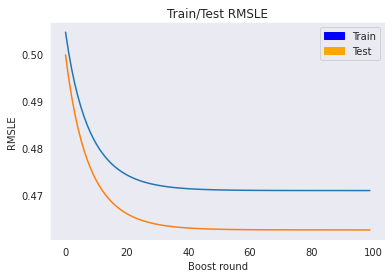

RMSLE Train set: 0.471042


In [55]:
# XGBoost
params = {'objective': 'reg:linear', 'gamma': 0,
          'subsample': 0.3, 'colsample_by*': 0.5, 'learning_rate': 0.1, 'max_depth': 15, 'lambda': 10,
          'booster': 'gblinear'}
xgb_results = {}
xgb_model = xgboost.train(dtrain=dmatrix_train, params=params, evals_result=xgb_results,
                          feval=rmsle, evals=[(dmatrix_test,'test'), (dmatrix_train,'train')], 
                          num_boost_round=500, early_stopping_rounds=5)

plotResult(xgb_results, cv=False)
print('RMSLE Train set:', xgb_results['train']['RMSLE'][-1])

# Final Results

In [56]:
eval(model_1, X_test, y_test,'linear regression')
print('******')
eval(model_2, X_test, y_test, 'Stochastic Gradient Descent')
print('******')
eval(model_2i, X_test, y_test, 'Lasso regression')
print('******')
eval(model_3i, X_test, y_test, 'Neural Network_default')
print('******')
eval(model_3ii, X_test, y_test, 'Neural Network_random')
print('******')
eval(model_3, X_test, y_test, 'Neural Network_gridsearch')
print('******')
eval(reg, X_test, y_test,'Gradient Boosting Regressor')
print('******')
print('Gradient Boost Linear Regression _ RMSLE Test set:', xgb_results['test']['RMSLE'][-1]) 

RMSLE of linear regression : 0.4841
R2 value of linear regression : 0.0032
Err value of linear regression : 0.4841
******
RMSLE of Stochastic Gradient Descent : 0.4984
R2 value of Stochastic Gradient Descent : -0.0038
Err value of Stochastic Gradient Descent : 0.4984
******
RMSLE of Lasso regression : 0.4836
R2 value of Lasso regression : 0.0022
Err value of Lasso regression : 0.4836
******
RMSLE of Neural Network_default : 0.5393
R2 value of Neural Network_default : -0.0802
Err value of Neural Network_default : 0.5393
******
RMSLE of Neural Network_random : 0.4796
R2 value of Neural Network_random : 0.0034
Err value of Neural Network_random : 0.4796
******
RMSLE of Neural Network_gridsearch : 0.4781
R2 value of Neural Network_gridsearch : 0.0003
Err value of Neural Network_gridsearch : 0.4781
******
RMSLE of Gradient Boosting Regressor : 0.4756
R2 value of Gradient Boosting Regressor : 0.0024
Err value of Gradient Boosting Regressor : 0.4756
******
Gradient Boost Linear Regression _ R

In [57]:
pred_y = xgb_model.predict(dmatrix_test)

submission = pd.DataFrame()
submission['MemberID'] = dataY2_df['MemberID']

pred_y = pred_y.clip(min=0)
pred_y = pred_y.clip(max=15)
# pred_y = pred_y.astype(int)

submission['DIH'] = pred_y
submission.groupby(['DIH']).size()

DIH
0.255387    1
0.257203    1
0.260449    1
0.260539    1
0.260838    1
           ..
0.819696    1
0.823048    1
0.832304    1
0.846934    1
0.874312    1
Length: 64277, dtype: int64

In [58]:
submission[submission['DIH']>=1]

,MemberID,DIH
